In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Flatten, Bidirectional, TimeDistributed,InputLayer, Lambda, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization, Dropout,Concatenate, AdditiveAttention
import time
import os
import json, collections, random
from PIL import Image

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'

if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)


# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 242s 0us/step


In [ ]:
annotation_file = '/content/annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
  annotations = json.load(f)

In [ ]:
len(annotations['annotations'])

414113

In [ ]:
annotations['annotations']

[{'caption': 'A very clean and well decorated empty bathroom',
  'id': 48,
  'image_id': 318556},
 {'caption': 'A panoramic view of a kitchen and all of its appliances.',
  'id': 67,
  'image_id': 116100},
 {'caption': 'A blue and white bathroom with butterfly themed wall tiles.',
  'id': 126,
  'image_id': 318556},
 {'caption': 'A panoramic photo of a kitchen and dining room',
  'id': 148,
  'image_id': 116100},
 {'caption': 'A graffiti-ed stop sign across the street from a red car ',
  'id': 173,
  'image_id': 379340},
 {'caption': 'A vandalized stop sign and a red beetle on the road',
  'id': 188,
  'image_id': 379340},
 {'caption': 'A bathroom with a border of butterflies and blue paint on the walls above it.',
  'id': 219,
  'image_id': 318556},
 {'caption': 'An angled view of a beautifully decorated bathroom.',
  'id': 255,
  'image_id': 318556},
 {'caption': 'The two people are walking down the beach.',
  'id': 272,
  'image_id': 134754},
 {'caption': 'A sink and a toilet inside

In [ ]:
# Group all captions together having the same image ID

image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<sos> {val['caption']} <eos>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.

train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [ ]:
train_captions = []
image_paths = []


for image in train_image_paths:
  captions = image_path_to_caption[image]
  train_captions.extend(captions)
  image_paths.extend([image]*len(captions))

<sos> A man feeding two giraffe next to a wooden fence. <eos>


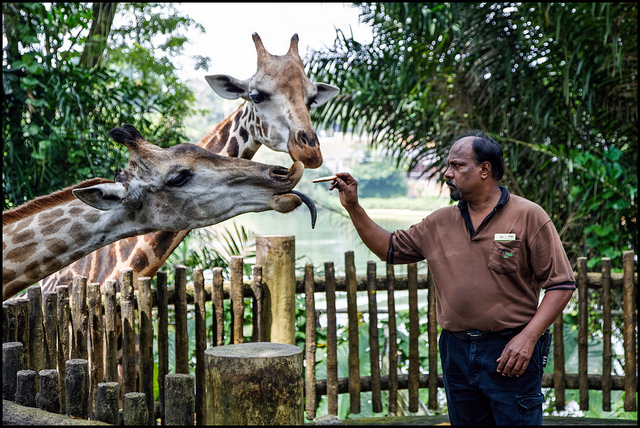

In [ ]:
print(train_captions[16])
Image.open(image_paths[16])

In [ ]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.io.decode_jpeg(img, channels =3)
  img = tf.keras.layers.Resizing(299,299)(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path
  # return img

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
input = image_model.input
output = image_model.layers[-1].output

image_features_extractor = Model(input, output)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
image_features_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [ ]:
import tqdm as tqdm
encode_train = sorted(set(image_paths))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls = tf.data.AUTOTUNE).batch(16)

batch_features_path_dict = {}
batch_features =[]
true_image_paths = []

for img, path in tqdm.tqdm(image_dataset): 
  batch_features_ = image_features_extractor(img)
  batch_features_ = tf.reshape(batch_features_, (batch_features_.shape[0], -1, batch_features_.shape[-1]))
  for bf, path_ in zip(batch_features_, path):
    batch_features_path_dict[path_.numpy().decode('utf-8')] = bf.numpy()
    path_of_feature = path_.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())
    

100%|██████████| 375/375 [01:43<00:00,  3.62it/s]


In [ ]:
len(batch_features_path_dict)

6000

In [ ]:
vocab_size = 5000
max_len = 50

tokenizer = TextVectorization(max_tokens = vocab_size, output_mode='int', output_sequence_length=max_len)
tokenizer.adapt(train_captions)

captions_int_to_word = {k:v for k,v in enumerate(tokenizer.get_vocabulary())}
captions_word_to_int = {v:k for k,v in enumerate(tokenizer.get_vocabulary())}

In [ ]:
captions_vector = tokenizer(train_captions)

In [ ]:
len(train_image_paths), len(image_path_to_caption), len(image_paths), len(train_captions)

(6000, 82783, 30014, 30014)

In [ ]:
img_to_cap_vector = collections.defaultdict(list)

for img, cap in zip(image_paths, captions_vector):
  img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys) * 0.8)

img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

In [ ]:
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_train[:10], cap_train[:10]

(['/content/train2014/COCO_train2014_000000151227.jpg',
  '/content/train2014/COCO_train2014_000000151227.jpg',
  '/content/train2014/COCO_train2014_000000151227.jpg',
  '/content/train2014/COCO_train2014_000000151227.jpg',
  '/content/train2014/COCO_train2014_000000151227.jpg',
  '/content/train2014/COCO_train2014_000000085933.jpg',
  '/content/train2014/COCO_train2014_000000085933.jpg',
  '/content/train2014/COCO_train2014_000000085933.jpg',
  '/content/train2014/COCO_train2014_000000085933.jpg',
  '/content/train2014/COCO_train2014_000000085933.jpg'],
 [<tf.Tensor: shape=(50,), dtype=int64, numpy=
  array([  3,   2,  41,  93,  11, 447,   2, 599,   4,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])>,
  <tf.Tensor: shape=(50,), dtype=int64, numpy=
  array([   3,    2,  378,   41,   93,   11,  632,   15,

In [ ]:
img_name_val = []
cap_val = []
captions_val_text = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])
  captions_val_text.extend(image_path_to_caption[imgv])

img_name_val[:10], cap_val[:10], captions_val_text[:10]

(['/content/train2014/COCO_train2014_000000270812.jpg',
  '/content/train2014/COCO_train2014_000000270812.jpg',
  '/content/train2014/COCO_train2014_000000270812.jpg',
  '/content/train2014/COCO_train2014_000000270812.jpg',
  '/content/train2014/COCO_train2014_000000270812.jpg',
  '/content/train2014/COCO_train2014_000000164010.jpg',
  '/content/train2014/COCO_train2014_000000164010.jpg',
  '/content/train2014/COCO_train2014_000000164010.jpg',
  '/content/train2014/COCO_train2014_000000164010.jpg',
  '/content/train2014/COCO_train2014_000000164010.jpg'],
 [<tf.Tensor: shape=(50,), dtype=int64, numpy=
  array([   3,  258,   20,  493, 1153,    5,   99,  294,   80,    7,  303,
            4,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0])>,
  <tf.Tensor: shape=(50,), dtype=int64, nump

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24011, 24011, 6003, 6003)

In [ ]:
batch_size = 64
buffer_size = 1000
num_steps = len(img_name_train) // batch_size
# Shape of the vector extracted from InceptionV3 is (64, 2048)
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

In [ ]:
# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(buffer_size).batch(batch_size)
# dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
class CNN_Encoder(tf.keras.Model):
  def __init__(self, embedding_dim):
    super(CNN_Encoder, self).__init__()
    self.fc = Dense(embedding_dim) #output-shape (batch_size, 64, emb_dim)

  def call(self, x): #input=shape of x - (batch_size, 64, 2048)
    x = self.fc(x)
    x = tf.nn.relu(x)
    return x

In [ ]:
#Test stack Encoder

x = tf.ones((16,64,2408))
encoder = CNN_Encoder(256)
values = encoder(x)
print ('Encoder ouput shape: {}'.format(encoder(x).shape))

Encoder ouput shape: (16, 64, 256)


In [ ]:
class Attention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, query, values):
     # values (CNN_encoder output) shape == (batch_size, 64, embedding_dim)
     # query (decoder output) shape == (batch_size, latent_state)
     hidden_with_time_axis = tf.expand_dims(query, 1) #reshaped to (batch_size, 1, latent_state)
     score = self.V(tf.nn.tanh(self.W1(hidden_with_time_axis)+self.W2(values))) #shape == (batch_size, 64, 1)
     attention_weights = tf.nn.softmax(score, axis=1) #attention_weights shape == (batch_size, 64, 1)

     context_vector = attention_weights * values #shape == (batch_size, 64, embedding_dim)
     context_vector = tf.reduce_sum(context_vector, axis = 1) #shape == (batch_size,embedding_dim)

     return context_vector, attention_weights

In [ ]:
#Test stack Attention

query = tf.ones((16, 128))

attention = Attention(10)
context_vec, attn_weights = attention(query, values)

print('Context vector shape: {}'.format(context_vec.shape))
print('Attention weights shape: {}'.format(attn_weights.shape))

Context vector shape: (16, 256)
Attention weights shape: (16, 64, 1)


In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.gru = GRU(self.units, return_state = True, return_sequences = True, recurrent_initializer= 'glorot_uniform')
    self.fc1 = Dense(self.units)
    self.fc2 = Dense(vocab_size)
    self.attention = Attention(self.units)

  def call(self, x, query, values):
    context_vector, attention_weights = self.attention(query, values)
    x = self.embedding(x) #shape == (batch_size,1, emb_dim)
    x = tf.concat([tf.expand_dims(context_vector, axis = 1),x], axis =-1) #shape ==(batch_size, 1, emb_dim + hidden_dim)
    output, state = self.gru(x) #output_shape ==(batch_size, 1, hidden_units), state == (batch_size, hidden_units)
    x = self.fc1(output) #shape = (batch_size, 1, units)
    x = tf.reshape(x, (x.shape[0], x.shape[-1])) #shape == (batch_size, units)
    x = self.fc2(x) #shape == (batch_size, vocab_size)
    return x, state, attention_weights #attn_weights shape == (batch_size, 64, 1)
  
  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [ ]:
#Test stack Decoder

x = tf.ones((16,1))
decoder = RNN_Decoder(300, 512, 5000)
x, state, attention_weights = decoder(x, query, values)


print ('Decoder ouput shape: {}'.format(x.shape))
print ('Decoder state shape: {}'.format(state.shape))
print ('Attention_weights shape: {}'.format(attention_weights.shape))

Decoder ouput shape: (16, 5000)
Decoder state shape: (16, 512)
Attention_weights shape: (16, 64, 1)


In [ ]:
embedding_dim = 256
units = 512
vocab_size = 5000


encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = real != 0
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = os.path.abspath('.')
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
@tf.function

def train_step(image_tensor, target):
  loss = 0

  query = decoder.reset_state(batch_size=target.shape[0])

  with tf.GradientTape() as tape:
    values = encoder(image_tensor)

    for i in range(0, target.shape[-1]-1):
      dec_input = tf.expand_dims(target[:,i],axis =-1)
      predictions, query, _ = decoder(dec_input,query,values)
      loss += loss_function(target[:,i+1], predictions)

  total_loss = (loss/int(target.shape[-1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
loss_plot = []

EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.0121
Epoch 1 Batch 100 Loss 1.1249
Epoch 1 Batch 200 Loss 0.9417
Epoch 1 Batch 300 Loss 0.7991
Epoch 1 Loss 1.018691
Time taken for 1 epoch 320.09 sec

Epoch 2 Batch 0 Loss 0.8235
Epoch 2 Batch 100 Loss 0.7217
Epoch 2 Batch 200 Loss 0.7667
Epoch 2 Batch 300 Loss 0.7525
Epoch 2 Loss 0.772278
Time taken for 1 epoch 180.08 sec

Epoch 3 Batch 0 Loss 0.7559
Epoch 3 Batch 100 Loss 0.7653
Epoch 3 Batch 200 Loss 0.7193
Epoch 3 Batch 300 Loss 0.6285
Epoch 3 Loss 0.694409
Time taken for 1 epoch 178.74 sec

Epoch 4 Batch 0 Loss 0.6345
Epoch 4 Batch 100 Loss 0.6811
Epoch 4 Batch 200 Loss 0.7083
Epoch 4 Batch 300 Loss 0.6778
Epoch 4 Loss 0.644686
Time taken for 1 epoch 176.39 sec

Epoch 5 Batch 0 Loss 0.5846
Epoch 5 Batch 100 Loss 0.5946
Epoch 5 Batch 200 Loss 0.5941
Epoch 5 Batch 300 Loss 0.5757
Epoch 5 Loss 0.603500
Time taken for 1 epoch 176.32 sec

Epoch 6 Batch 0 Loss 0.5766
Epoch 6 Batch 100 Loss 0.5735
Epoch 6 Batch 200 Loss 0.5785
Epoch 6 Batch 300 Loss 0.6061
Epoch 6

In [ ]:
for (batch, (img_tensor, target)) in enumerate(dataset):
  print(img_tensor), print(target.shape)
  break


tf.Tensor(
[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.33485347 0.         ... 0.         0.         0.        ]
  [0.02014637 0.28319073 0.         ... 0.         0.         0.03767639]
  ...
  [3.0617995  0.         0.         ... 0.         1.3199567  2.8304207 ]
  [1.7214141  0.5470106  0.         ... 0.33621836 1.6689814  3.4732716 ]
  [1.1375616  0.33584315 0.         ... 0.28078654 0.83077127 3.1783535 ]]

 [[0.         0.         0.         ... 0.1657258  0.         0.3294491 ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.13570014 0.        ]
  ...
  [0.         0.         0.         ... 0.         0.5011238  0.        ]
  [0.         0.         0.         ... 0.         0.5053225  0.        ]
  [0.         0.08002613 0.         ... 0.         0.14779146 0.28435954]]

 [[0.         0.26835686 1.5606067  ... 0.13961591 0.         0.        ]
  [0.      

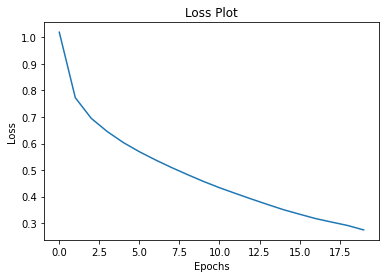

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image_path):
  caption = 'sos'
  attention_plot = np.zeros((max_len, attention_features_shape))
  query = decoder.reset_state(batch_size=1)
  img, img_path = load_image(image_path)
  img_tensor = image_features_extractor(tf.expand_dims(img,0))
  img_tensor = tf.reshape(img_tensor, (1,-1, img_tensor.shape[-1]))
  values = encoder(img_tensor)

  dec_input = tf.expand_dims([captions_word_to_int['sos']],0)

  for i in range(50):
    pred, query, attention_weights = decoder(dec_input, query, values)
    attention_plot[i] = tf.reshape(attention_weights, (1,attention_features_shape)).numpy()
    dec_input = tf.expand_dims([np.argmax(pred)],0)
    caption = caption + " " + captions_int_to_word[np.argmax(pred)]
    if captions_int_to_word[np.argmax(pred)] == 'eos':
      break
  leng_ = caption.split()
  attention_plot = attention_plot[:len(leng_)-1,:]
  return attention_plot, caption


In [ ]:
def plot_attention(image, result, attention_plot):
    
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(20, 20))

    caption = result.split()[1:]

    len_result = len(caption)

    for i in range(len_result):
        temp_att = np.resize(attention_plot[i,:], (8, 8))
        grid_size = max(int(np.ceil(len_result/3)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(caption[i])
        img = plt.imshow(temp_image)
        plt.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
        plt.axis('Off')

    plt.tight_layout()
    plt.show()

In [ ]:
rand_img =np.random.randint(0, len(img_name_val))
attention_plot, caption = evaluate(img_name_val[rand_img])
print('Real Caption :', captions_val_text[rand_img])
print('Gen Caption  :', caption)


Real Caption : <sos> Two giraffes in a grassy area with body of water in the foreground. <eos>
Gen Caption  : sos two giraffes are standing next to the middle of the plains with trees eos


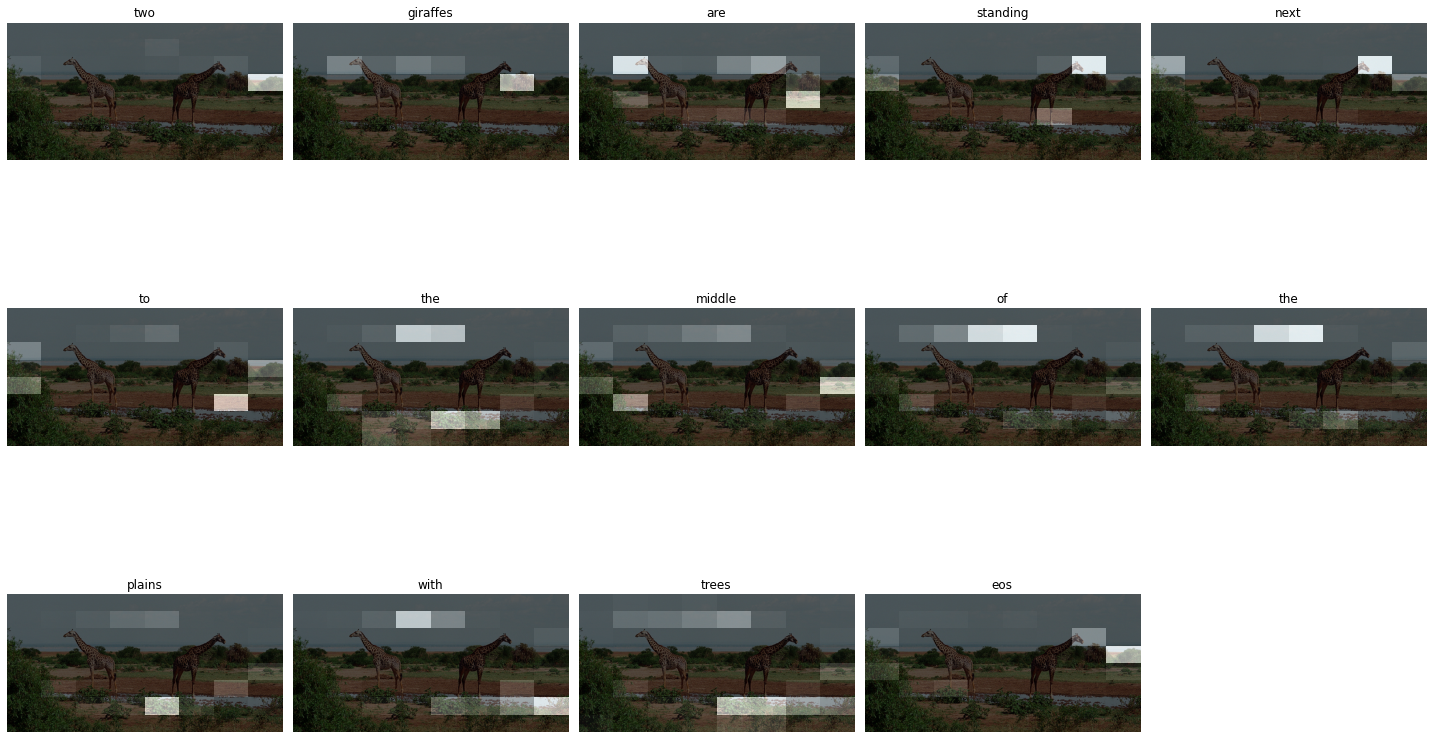

In [ ]:
plot_attention(img_name_val[rand_img], caption, attention_plot)

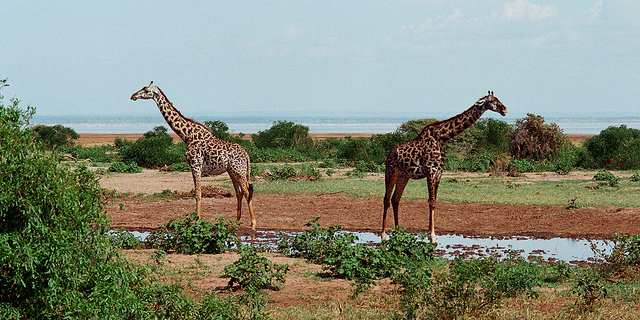

In [ ]:
Image.open(img_name_val[rand_img])